# Memory Agent

## Review

We've shown how to [save memories to a collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection), rather than a single schema. 

We also improved our chatbot by adding a tool that allows it to *decide when to save memories*, making it agent.

## Goals

Now, let's put it all together into an agent. 

The agent can save memories to a collection, and update them. 


In [ ]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

First, we'll define the state of our agent. 

In [18]:
from dataclasses import dataclass
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages
from typing_extensions import Annotated

@dataclass(kw_only=True)
class State:
    """Main graph state."""

    messages: Annotated[list[AnyMessage], add_messages]
    """The messages in the conversation."""

## Tool definition 

Next, we'll define the tool that will format and upsert memories to the store. 

We use [InjectedToolArg](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.InjectedState), which instructs the model to ignore the argument when generating a tool call. 

In [2]:
import uuid
from typing import Annotated, Optional

from langchain_core.runnables import RunnableConfig
from langchain_core.tools import InjectedToolArg
from langgraph.store.base import BaseStore

def upsert_memory(
    content: str,
    context: str,
    *,
    memory_id: Optional[uuid.UUID] = None,
    # Hide these arguments from the model.
    config: Annotated[RunnableConfig, InjectedToolArg],
    store: Annotated[BaseStore, InjectedToolArg]):
    """Upsert a memory in the database.

    If a memory conflicts with an existing one, then just UPDATE the
    existing one by passing in memory_id - don't create two memories
    that are the same. If the user corrects a memory, UPDATE it.

    Args:
        content: The main content of the memory. For example:
            "User expressed interest in learning about French."
        context: Additional context for the memory. For example:
            "This was mentioned while discussing career options in Europe."
        memory_id: ONLY PROVIDE IF UPDATING AN EXISTING MEMORY.
        The memory to overwrite.
    """
    mem_id = memory_id or uuid.uuid4()
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    store.put(
        ("memories", user_id),
        key=str(mem_id),
        value={"content": content, "context": context},
    )
    return f"Stored memory {memory_id}"

## Graph definition 

Next, we'll define our graph using a control flow similar to what we used before. 



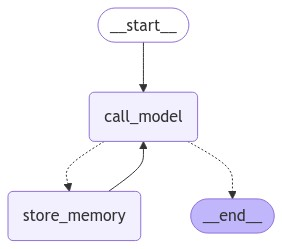

In [11]:
from IPython.display import Image, display

import asyncio
from datetime import datetime
 
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langgraph.graph import END, StateGraph
from langgraph.store.base import BaseStore

from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver

from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

def call_model(state: State, config: RunnableConfig, *, store: BaseStore) -> dict:

    """Extract the user's state from the conversation and update the memory."""
    user_id = config["configurable"]["user_id"]

    # Retrieve the most recent memories for context
    memories = store.search(
        ("memories", user_id), limit=10
    )

    # Format memories for inclusion in the prompt
    formatted = "\n".join(f"[{mem.key}]: {mem.value}" for mem in memories)
    if formatted:
        formatted = f"""
    <memories>
    {formatted}
    </memories>"""
    
    # Prepare the system prompt with user memories and current time
    # This helps the model understand the context and temporal relevance
    # TODO: Discuss with Will. Tool calling not occurring, as expected.
    instructions = """You are a helpful and friendly chatbot. Get to know the user! 
    
    Ask questions! Be spontaneous! 

    Save the user's memories as the conversation progresses.

    Here is any user information that you've already learned:

    {user_info}

    System Time: {time}"""

    # Format the instructions with the user memories and current time
    system_prompt = instructions.format(user_info=formatted, time=datetime.now().isoformat())

    # Invoke the language model with the prepared prompt and tools
    # "bind_tools" gives the LLM the JSON schema for all tools in the list so it knows how
    # to use them.
    msg = model.bind_tools([upsert_memory]).invoke(
        [SystemMessage(content=system_prompt)] + state.messages,
    )
    return {"messages": [msg]}

def store_memory(state: State, config: RunnableConfig, *, store: BaseStore):

    # Extract tool calls from the last message
    tool_calls = state.messages[-1].tool_calls

    # Execute all upsert_memory calls
    saved_memories = [
        
            upsert_memory(**tc["args"], config=config, store=store)
            for tc in tool_calls
        
    ]

    # Format the results of memory storage operations
    # This provides confirmation to the model that the actions it took were completed
    results = [
        ToolMessage(content=mem, tool_call_id=tc["id"])
        for tc, mem in zip(tool_calls, saved_memories)
    ]
    return {"messages": results}

def route_message(state: State):
    """Determine the next step based on the presence of tool calls."""
    msg = state.messages[-1]
    if msg.tool_calls:
        # If there are tool calls, we need to store memories
        return "store_memory"
    # Otherwise, finish; user can send the next message
    return END

# Create the graph + all nodes
builder = StateGraph(State)

# Define the flow of the memory extraction process
builder.add_node(call_model)
builder.add_edge("__start__", "call_model")
builder.add_node(store_memory)
builder.add_conditional_edges("call_model", route_message, ["store_memory", END])
# Right now, we're returning control to the user after storing a memory
# Depending on the model, you may want to route back to the model
# to let it first store memories, then generate a response
builder.add_edge("store_memory", "call_model")

# Store from cross-thread memory
in_memory_store = InMemoryStore()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=MemorySaver(), store=in_memory_store)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [12]:
# We supply a user ID for across-thread memory as well as a thread ID for within-thread memory
config = {"configurable": {"thread_id": "2", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="Hi! My name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! My name is Lance
================================== Ai Message ==================================

Hi Lance! It's great to meet you. How's your day going so far?


In [13]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Great! Today I biked in the morning in San Francisco.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Great! Today I biked in the morning in San Francisco.
================================== Ai Message ==================================
Tool Calls:
  upsert_memory (call_gQbC2Yxv9MeJARKGqg295sTF)
 Call ID: call_gQbC2Yxv9MeJARKGqg295sTF
  Args:
    content: Lance biked in the morning in San Francisco.
    context: Lance shared this while discussing his day.
================================= Tool Message =================================

Stored memory None
================================== Ai Message ==================================

That sounds like a fantastic way to start the day! San Francisco must be beautiful in the morning. Do you often go biking there?


In [14]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Yes, I went to the Marin headlands today.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, I went to the Marin headlands today.
================================== Ai Message ==================================
Tool Calls:
  upsert_memory (call_8RIurS4OIr9KG3acf41dawyt)
 Call ID: call_8RIurS4OIr9KG3acf41dawyt
  Args:
    content: Lance biked to the Marin Headlands in San Francisco.
    context: Lance mentioned this while discussing his morning biking routine.
================================= Tool Message =================================

Stored memory None
================================== Ai Message ==================================

The Marin Headlands are such a stunning place to bike! The views must have been amazing. Do you have a favorite spot or trail there?


In [15]:
# Chat with the chatbot
input_messages = [HumanMessage(content="I like Miwok trail. Also, I like bakeries after biking.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like Miwok trail. Also, I like bakeries after biking.
================================== Ai Message ==================================
Tool Calls:
  upsert_memory (call_nn0ye6VknOUMygPcad53xqWg)
 Call ID: call_nn0ye6VknOUMygPcad53xqWg
  Args:
    content: Lance likes the Miwok trail in the Marin Headlands.
    context: Lance shared this while discussing his favorite biking spots.
  upsert_memory (call_mA8mhnwjzl27MvUHVLtlxKVx)
 Call ID: call_mA8mhnwjzl27MvUHVLtlxKVx
  Args:
    content: Lance enjoys visiting bakeries after biking.
    context: Lance mentioned this while discussing his post-biking routine.
================================= Tool Message =================================

Stored memory None
================================== Ai Message ==================================

The Miwok Trail is a great choice! And treating yourself to a visit to a bakery afterward sounds like the perfect reward

In [16]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in in_memory_store.search(("memories", user_id)):
    print(memory.value)

{'content': 'Lance biked in the morning in San Francisco.', 'context': 'Lance shared this while discussing his day.'}
{'content': 'Lance biked to the Marin Headlands in San Francisco.', 'context': 'Lance mentioned this while discussing his morning biking routine.'}
{'content': 'Lance likes the Miwok trail in the Marin Headlands.', 'context': 'Lance shared this while discussing his favorite biking spots.'}
{'content': 'Lance enjoys visiting bakeries after biking.', 'context': 'Lance mentioned this while discussing his post-biking routine.'}


Now we can create a new thread and chat with the chatbot again.

It should retain the memories from the previous thread!

In [17]:
# We supply a user ID for across-thread memory as well as a thread ID for within-thread memory
config = {"configurable": {"thread_id": "2", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="What bakeries would you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries would you recommend for me?
================================== Ai Message ==================================

Since you enjoy visiting bakeries after biking, especially around the Marin Headlands, here are a few recommendations in the San Francisco area:

1. **Tartine Bakery** - Known for its delicious pastries and bread, it's a must-visit for any bakery lover.
2. **B. Patisserie** - Offers a delightful selection of French pastries, including their famous kouign-amann.
3. **Arsicault Bakery** - Renowned for its croissants, this place is perfect for a post-ride treat.
4. **Craftsman and Wolves** - Known for its inventive pastries and the "Rebel Within," a savory muffin with a soft-cooked egg inside.
5. **Noe Valley Bakery** - A neighborhood favorite with a wide variety of baked goods.

Do any of these sound like a place you'd like to try, or do you have a favorite bakery already?


## LangSmith Trace

https://smith.langchain.com/public/1d1c129e-7e9f-4362-a96f-56b5955d8ab8/r

## Template 

https://github.com/langchain-ai/memory-agent